In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pyhf
from pathlib import Path

from publik.reweight import eos_modifier
from publik.weights import utils as wutils
from publik.reweight import utils as rwutils
from publik.reweight import plot

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use(Path('../style.mplstyle'))
# matplotlib.style.use('default')
matplotlib.rcParams["text.usetex"] = False

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# A simple example of how to do a fit with the model independent likelihood

## Setup the custom modifier

First we need to get the distribution of the kinematic variable, $q^2$ in the analysis binning and the corresponding binning of the variable.

In [2]:
# Get the q2 distribution
q2json = '../pyhf_inputs/pyhf_Bplus2Kplus_v24_with_continuum_weights_no_ff_q2.json'

q2dist, q2binning = rwutils.getQ2Distributions(q2json)
q2binning_cut = np.where(q2binning > 0, q2binning, 0)
q2binning_cut = np.where(q2binning_cut < wutils.kinlim(), q2binning_cut, wutils.kinlim())

Now we set up the custom modifier, knowing the $q^2$ binning and distribution. Then we can create the `pyhf` model.

In [3]:
# Set up the custom modifier
expanded_pyhf = eos_modifier.add(q2binning_cut, q2dist)

# Get the pyhf model and data
pdf, data = rwutils.getPDF("../pyhf_inputs/pyhf_Bplus2Kplus_v24_with_continuum_weights_no_ff_wilson.json", validate=False, modifier_set=expanded_pyhf)

INFO:EOS:Creating analysis with 8 priors, 2 EOS-wide constraints, 0 global options, 0 manually-entered constraints and 0 fixed parameters.
INFO:EOS:Optimization goal achieved after 163 function evaluations
INFO:EOS:Creating analysis with 8 priors, 2 EOS-wide constraints, 0 global options, 0 manually-entered constraints and 0 fixed parameters.
INFO:EOS:Optimization goal achieved after 163 function evaluations
INFO:EOS:Creating analysis with 8 priors, 2 EOS-wide constraints, 0 global options, 0 manually-entered constraints and 0 fixed parameters.
INFO:EOS:Creating analysis with 8 priors, 2 EOS-wide constraints, 0 global options, 0 manually-entered constraints and 0 fixed parameters.
INFO:EOS:Optimization goal achieved after 163 function evaluations


Pre-runs:   0%|          | 0/3 [00:00<?, ?it/s]

INFO:EOS:Prerun 0 out of 3
INFO:EOS:Prerun 0: acceptance rate is   2%
INFO:EOS:Prerun 1 out of 3
INFO:EOS:Prerun 1: acceptance rate is   1%
INFO:EOS:Prerun 2 out of 3
INFO:EOS:Prerun 2: acceptance rate is   4%
INFO:EOS:Main run: started ...


Main run:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:EOS:Main run: acceptance rate is  11%
INFO:pyhf.pdf:adding modifier cvl (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier csl (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier ctl (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier ffpca0 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier ffpca1 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier ffpca2 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier ffpca3 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier ffpca4 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier ffpca5 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier ffpca6 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier ffpca7 (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier corr_neutralGamma_c (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier corr_neutralUnmatched_c (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier corr_pid_c1 (1 new nuisance parameters)
INFO:pyhf.pdf:adding 

We can check the modifiers and the constraints

In [4]:
pdf.config.par_map

{'cvl': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x7f6033619c10>},
 'csl': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x7f6033619c40>},
 'ctl': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x7f6033619bb0>},
 'ffpca0': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7f6033619be0>},
 'ffpca1': {'slice': slice(4, 5, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7f60338275e0>},
 'ffpca2': {'slice': slice(5, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7f6033827640>},
 'ffpca3': {'slice': slice(6, 7, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7f6033827730>},
 'ffpca4': {'slice': slice(7, 8, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x7f60335f51c0>},
 'ffpca5': {'slice': slice(8, 9, None),
 

## Fit

Given the model, we can now perform a simple maximum likelihood fit.

We can set the initial parameters and bounds. Since we are fitting the theory model and this includes the signal normalization, we also fix the signal strength.

In [5]:
# Here we can modify the initial parameters:
init_pars = pdf.config.suggested_init()
# init_pars[pdf.config.par_map['cvl']['slice']] = [0.0]
# init_pars[pdf.config.par_map['csl']['slice']] = [0.0]
# init_pars[pdf.config.par_map['ctl']['slice']] = [0.0]

# Here we can modify the parameter bounds:
pdf.config.par_map['mu']['paramset'].suggested_bounds=[(-1000,1000)]
par_bounds = pdf.config.suggested_bounds()

# Here we can fix parameters:
fixed = np.full(len(pdf.config.par_names), False)
fixed[pdf.config.poi_index]=True
# fixed[pdf.config.par_map['cvl']['slice']]=[True]
# fixed[pdf.config.par_map['csl']['slice']]=[True]
# fixed[pdf.config.par_map['ctl']['slice']]=[True]
# for i in range(8):
#     fixed[pdf.config.par_map[f'ffpca{i}']['slice']]=[True]

`pyhf` supports a number of optimizers. `scipy` is the most stable in general, but does not return uncertainties. `minuit` will return uncertainties. Below we perforn fits with both optimizers.

### Scipy optimizer

In [6]:
pyhf.set_backend("numpy", pyhf.optimize.scipy_optimizer())
   
best_fit, twice_nll = pyhf.infer.mle.fit(data, 
                                        pdf, 
                                        init_pars, 
                                        par_bounds, 
                                        fixed.tolist(),
                                        return_fitted_val=True, 
                                    #  return_result_obj=True
                                        )


best_fit_dict = {k: best_fit[v["slice"]].tolist() for k, v in pdf.config.par_map.items()}
        
results_scipy = { 'twice_nll': float(twice_nll), 
            'fit_values': best_fit_dict}

INFO:EOS:Optimization goal achieved after 16 function evaluations
/nfs/dust/belle1/user/lorenzg/publik/publik/weights/utils.py:160: RuntimeWarning: invalid value encountered in divide
  weights = BR/norm
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 137 function evaluations
INFO:EOS:Optimization goal achieved after 140 function evaluations
INFO:EOS:Optimization goal achieved after 135 function evaluations
INFO:EOS:Optimization goal achieved after 136 function evaluations
INFO:EOS:Optimization goal achieved after 135 function evaluations
INFO:EOS:Optimization goal achieved after 139 function evaluations
INFO:EOS:Optimization goal achieved after 138 function evaluations
INFO:EOS:Optimization goal achieved after 129 function eval

### Minuit optimizer

In [7]:
pyhf.set_backend("numpy", pyhf.optimize.minuit_optimizer(verbose=True, strategy=2, tolerance=1e-10))

best_fit, twice_nll, OptimizeResult = pyhf.infer.mle.fit(
            data,
            pdf,
            init_pars,
            par_bounds,
            fixed.tolist(),
            return_uncertainties=True,
            return_fitted_val=True,
            return_result_obj=True)

best_fit_dict = {k: best_fit[v["slice"]].tolist() for k, v in pdf.config.par_map.items()}
        
results = { 'twice_nll': float(twice_nll), 
            'fit_values': best_fit_dict}

INFO:EOS:Optimization goal achieved after 135 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 146 function evaluations
INFO:EOS:Optimization goal achieved after 150 function evaluat

W MnPosDef Matrix forced pos-def by adding to diagonal 0.0379326


INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 141 function evaluations
INFO:EOS:Optimization goal achieved after 129 function evaluations
INFO:EOS:Optimization goal achieved after 149 function evaluations
INFO:EOS:Optimization goal achieved after 127 function evaluations
INFO:EOS:Optimization goal achieved after 139 function evaluations
INFO:EOS:Optimization goal achieved after 163 function evaluations
INFO:EOS:Optimization goal achieved after 127 function evaluat

W VariableMetricBuilder Reached machine accuracy limit; Edm 2.60462e-10 is smaller than machine limit 2.63313e-06 while 1.19209e-10 was requested


INFO:EOS:Optimization goal achieved after 149 function evaluations
INFO:EOS:Optimization goal achieved after 149 function evaluations
INFO:EOS:Optimization goal achieved after 149 function evaluations
INFO:EOS:Optimization goal achieved after 149 function evaluations
INFO:EOS:Optimization goal achieved after 149 function evaluations
INFO:EOS:Optimization goal achieved after 149 function evaluations
INFO:EOS:Optimization goal achieved after 149 function evaluations
INFO:EOS:Optimization goal achieved after 130 function evaluations
INFO:EOS:Optimization goal achieved after 134 function evaluations
INFO:EOS:Optimization goal achieved after 133 function evaluations
INFO:EOS:Optimization goal achieved after 133 function evaluations
INFO:EOS:Optimization goal achieved after 132 function evaluations
INFO:EOS:Optimization goal achieved after 135 function evaluations
INFO:EOS:Optimization goal achieved after 135 function evaluations
INFO:EOS:Optimization goal achieved after 133 function evaluat

In [8]:
results

{'twice_nll': -44.176529076406666,
 'fit_values': {'cvl': [[7.165604515597823, 5.095356033356206]],
  'csl': [[2.763619835016891e-05, 44.524149403815926]],
  'ctl': [[-4.225620452061318e-06, 22.83548151507923]],
  'ffpca0': [[-0.0010219064065801033, 0.9933252202126146]],
  'ffpca1': [[-0.0009826836696332506, 0.9933274378130352]],
  'ffpca2': [[0.0004984804819773915, 0.9933312578493619]],
  'ffpca3': [[-0.00025996065076910966, 0.9933439234861643]],
  'ffpca4': [[-0.0003579540263977093, 0.9933422870175]],
  'ffpca5': [[-5.484938200116642e-05, 0.9933452255261361]],
  'ffpca6': [[4.045450074521839e-05, 0.9933453204179854]],
  'ffpca7': [[-6.390574146481658e-05, 0.9933454331833703]],
  'corr_neutralGamma_c': [[0.17106345819363397, 0.9841969170309413]],
  'corr_neutralUnmatched_c': [[0.6748663209799657, 0.9256277934606102]],
  'corr_pid_c1': [[0.06448221330176318, 0.9911223623381701]],
  'corr_pid_c2': [[0.03156359823261649, 0.9923971144131944]],
  'corr_pid_c3': [[-0.028931741852173024, 0.9

We can plot the pulls of all the constrained parameters.

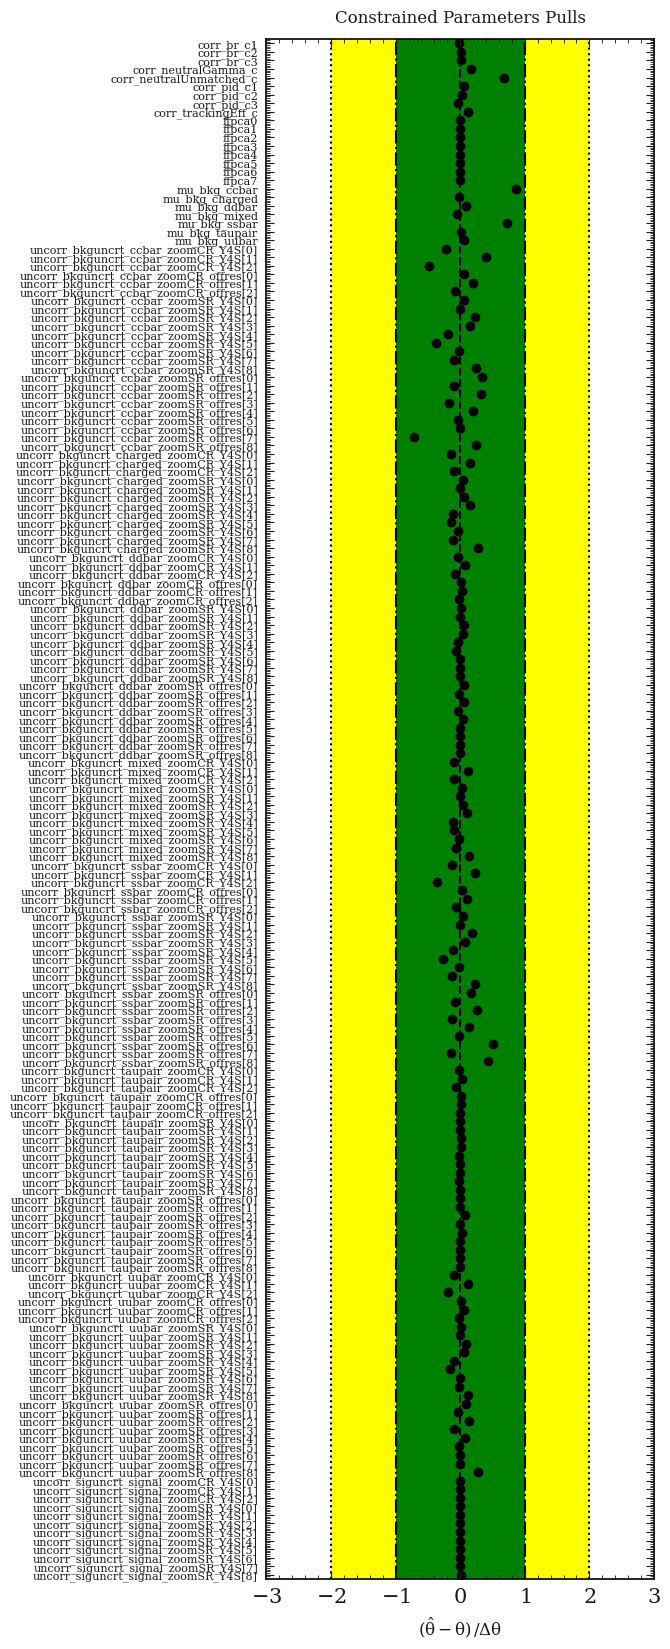

In [9]:
plot.pulls_wrt_nominal(pdf, best_fit[:,0])